# Figure 2.c : Showing WNet3D performance on additional datasets

- Show that self-supervised model can perform well on additional datasets, without requiring any additional training.

In [1]:
import numpy as np
from tifffile import imread
import sys
import numpy as np

import pyclesperanto_prototype as cle
from stardist.matching import matching_dataset
sys.path.append("../..")

from utils import *
from plots import *
print("Used GPU: ", cle.get_device())
show_params()
#################
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = False

Used GPU:  <Intel(R) UHD Graphics 620 on Platform: Intel(R) OpenCL (1 refs)>
Plot parameters (set in plots.py) : 
- COLORMAP : ████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 20
- Title font size : 25.0
- Label font size : 20.0


In [2]:
%load_ext autoreload
%autoreload 2

## Data

In [3]:
data_path = DATA_PATH / "RESULTS/WNET OTHERS/"

# list all folders in the data path
folders = [x for x in data_path.iterdir() if x.is_dir()]
folders

[WindowsPath('C:/Users/Cyril/Desktop/Code/CELLSEG_BENCHMARK/RESULTS/WNET OTHERS/Mouse-Skull-Nuclei-CBG'),
 WindowsPath('C:/Users/Cyril/Desktop/Code/CELLSEG_BENCHMARK/RESULTS/WNET OTHERS/Platynereis-ISH-Nuclei-CBG'),
 WindowsPath('C:/Users/Cyril/Desktop/Code/CELLSEG_BENCHMARK/RESULTS/WNET OTHERS/Platynereis-Nuclei-CBG')]

In [4]:
def get_predictions(path):
    return [imread(f) for f in path.glob("*.tif")]
#################
gt_folder = "labels"
mouse_skull = get_predictions(folders[0] / gt_folder)[0]
platynereis_ISH = get_predictions(folders[1] / gt_folder)[0]
platynereis = get_predictions(folders[2] / gt_folder)[0]

In [5]:
prediction_folder = "pred"
mouse_skull_pred = get_predictions(folders[0] / prediction_folder)[0]
platynereis_ISH_pred = get_predictions(folders[1] / prediction_folder)[0]
platynereis_pred = get_predictions(folders[2] / prediction_folder)[0]

In [6]:
# get second channel of predictions
mouse_skull_pred = mouse_skull_pred[1]
platynereis_ISH_pred = platynereis_ISH_pred[1]
platynereis_pred = platynereis_pred[1]

## Computations

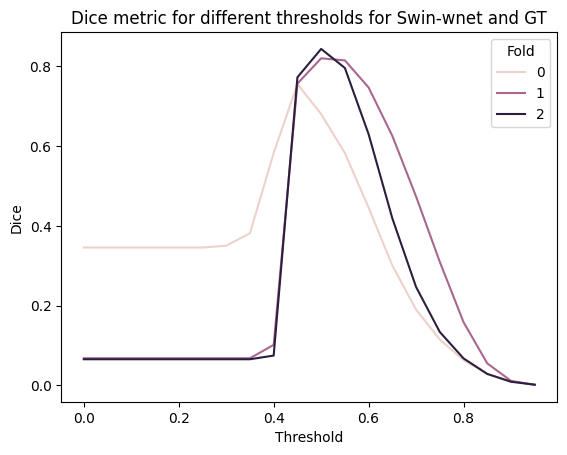

In [7]:
# plot dice metric for several thresholds for swin-wnet and GT using a dataframe that records which threshold and fold the dice was calculated for
GT_labels = [mouse_skull, platynereis_ISH, platynereis]
predictions = [mouse_skull_pred, platynereis_ISH_pred, platynereis_pred]

thresh = np.arange(0, 1, 0.05)
rows = []
for t in thresh:
    for i, (gt, pred) in enumerate(zip(GT_labels, predictions)):
        dices_row = {"Threshold": t, "Fold": i, "Dice": dice_coeff(
            np.where(gt > 0, 1, 0),
            np.where(pred > t, 1, 0)
            )}
        rows.append(dices_row)
        
dices_df = pd.DataFrame(rows)

sns.lineplot(data=dices_df, x="Threshold", y="Dice", hue="Fold")
plt.title("Dice metric for different thresholds for Swin-wnet and GT")
plt.show()

In [8]:
dices_df.groupby("Threshold").mean().sort_values("Dice", ascending=False).head(5)

,Fold,Dice
Threshold,,
0.50,1.0,0.781214
0.45,1.0,0.761517
0.55,1.0,0.731137
0.60,1.0,0.607459
0.65,1.0,0.448351


In [9]:
predictions_thresholded = [np.where(pred > 0.5, 1, 0) for pred in predictions]

In [10]:
mouse_skull_instance = np.array(
    cle.voronoi_otsu_labeling(predictions_thresholded[0], outline_sigma=2, spot_sigma=5)
)
platynereis_ISH_instance = np.array(
    cle.voronoi_otsu_labeling(predictions_thresholded[1], outline_sigma=0.5, spot_sigma=3.5)
)
platynereis_instance = np.array(
    cle.voronoi_otsu_labeling(predictions_thresholded[2], outline_sigma=0.5, spot_sigma=1.5)
)

## Plots

Validating on Mouse skull
********************
Validating on Platynereis ISH
********************
Validating on Platynereis
********************


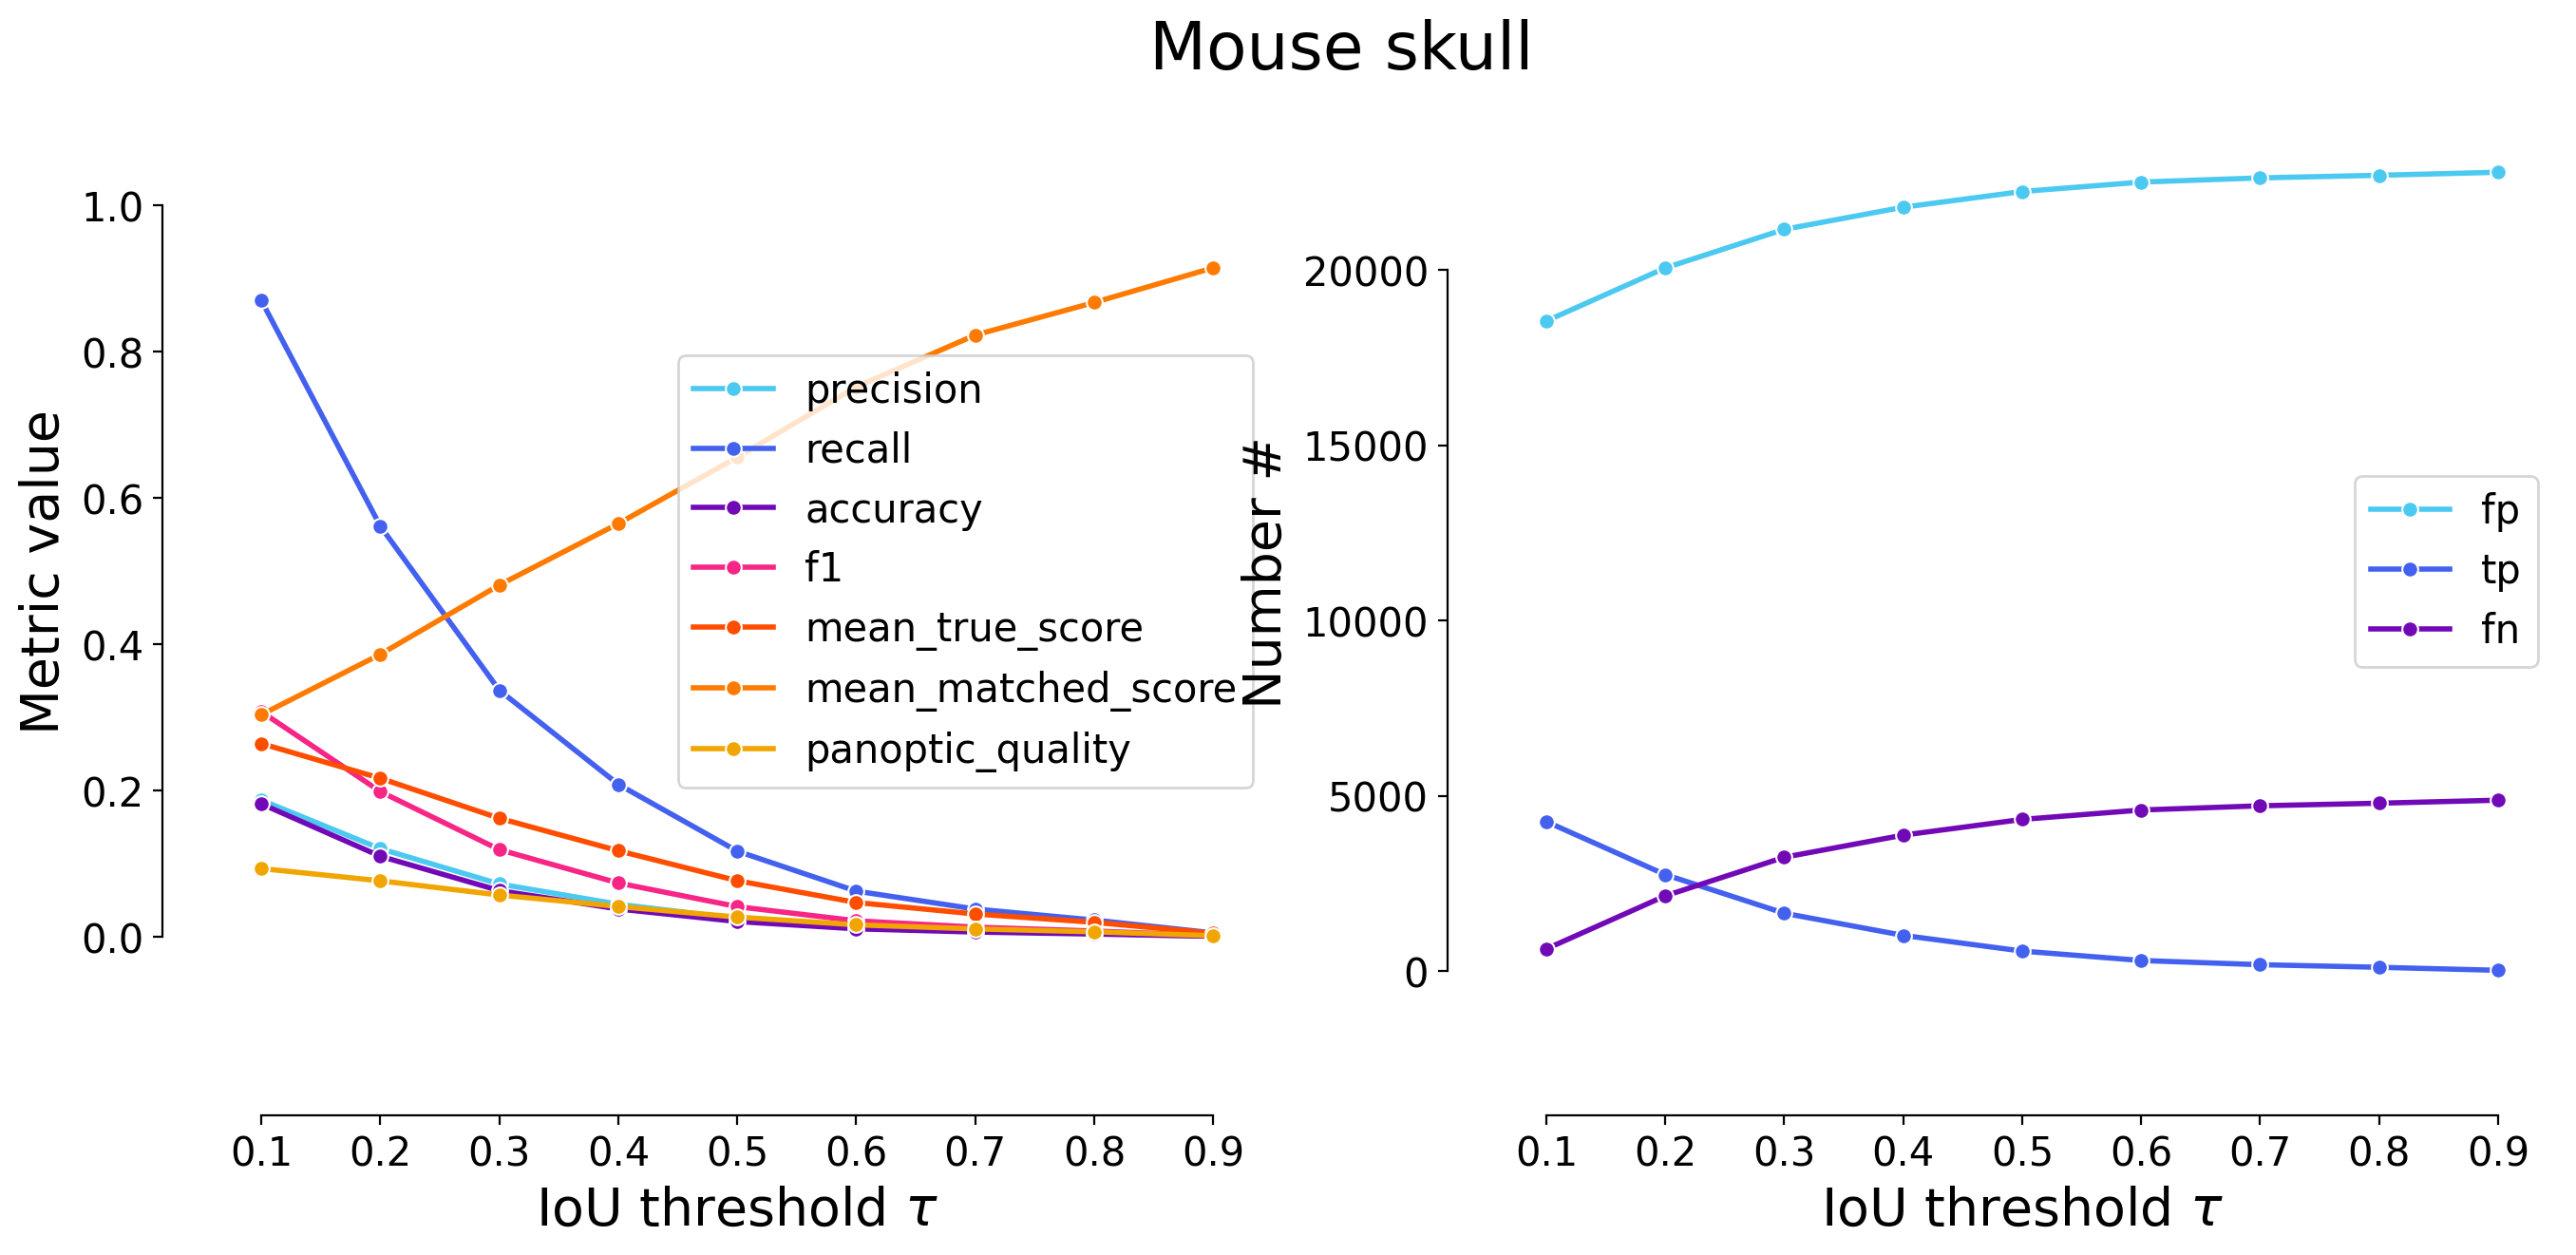

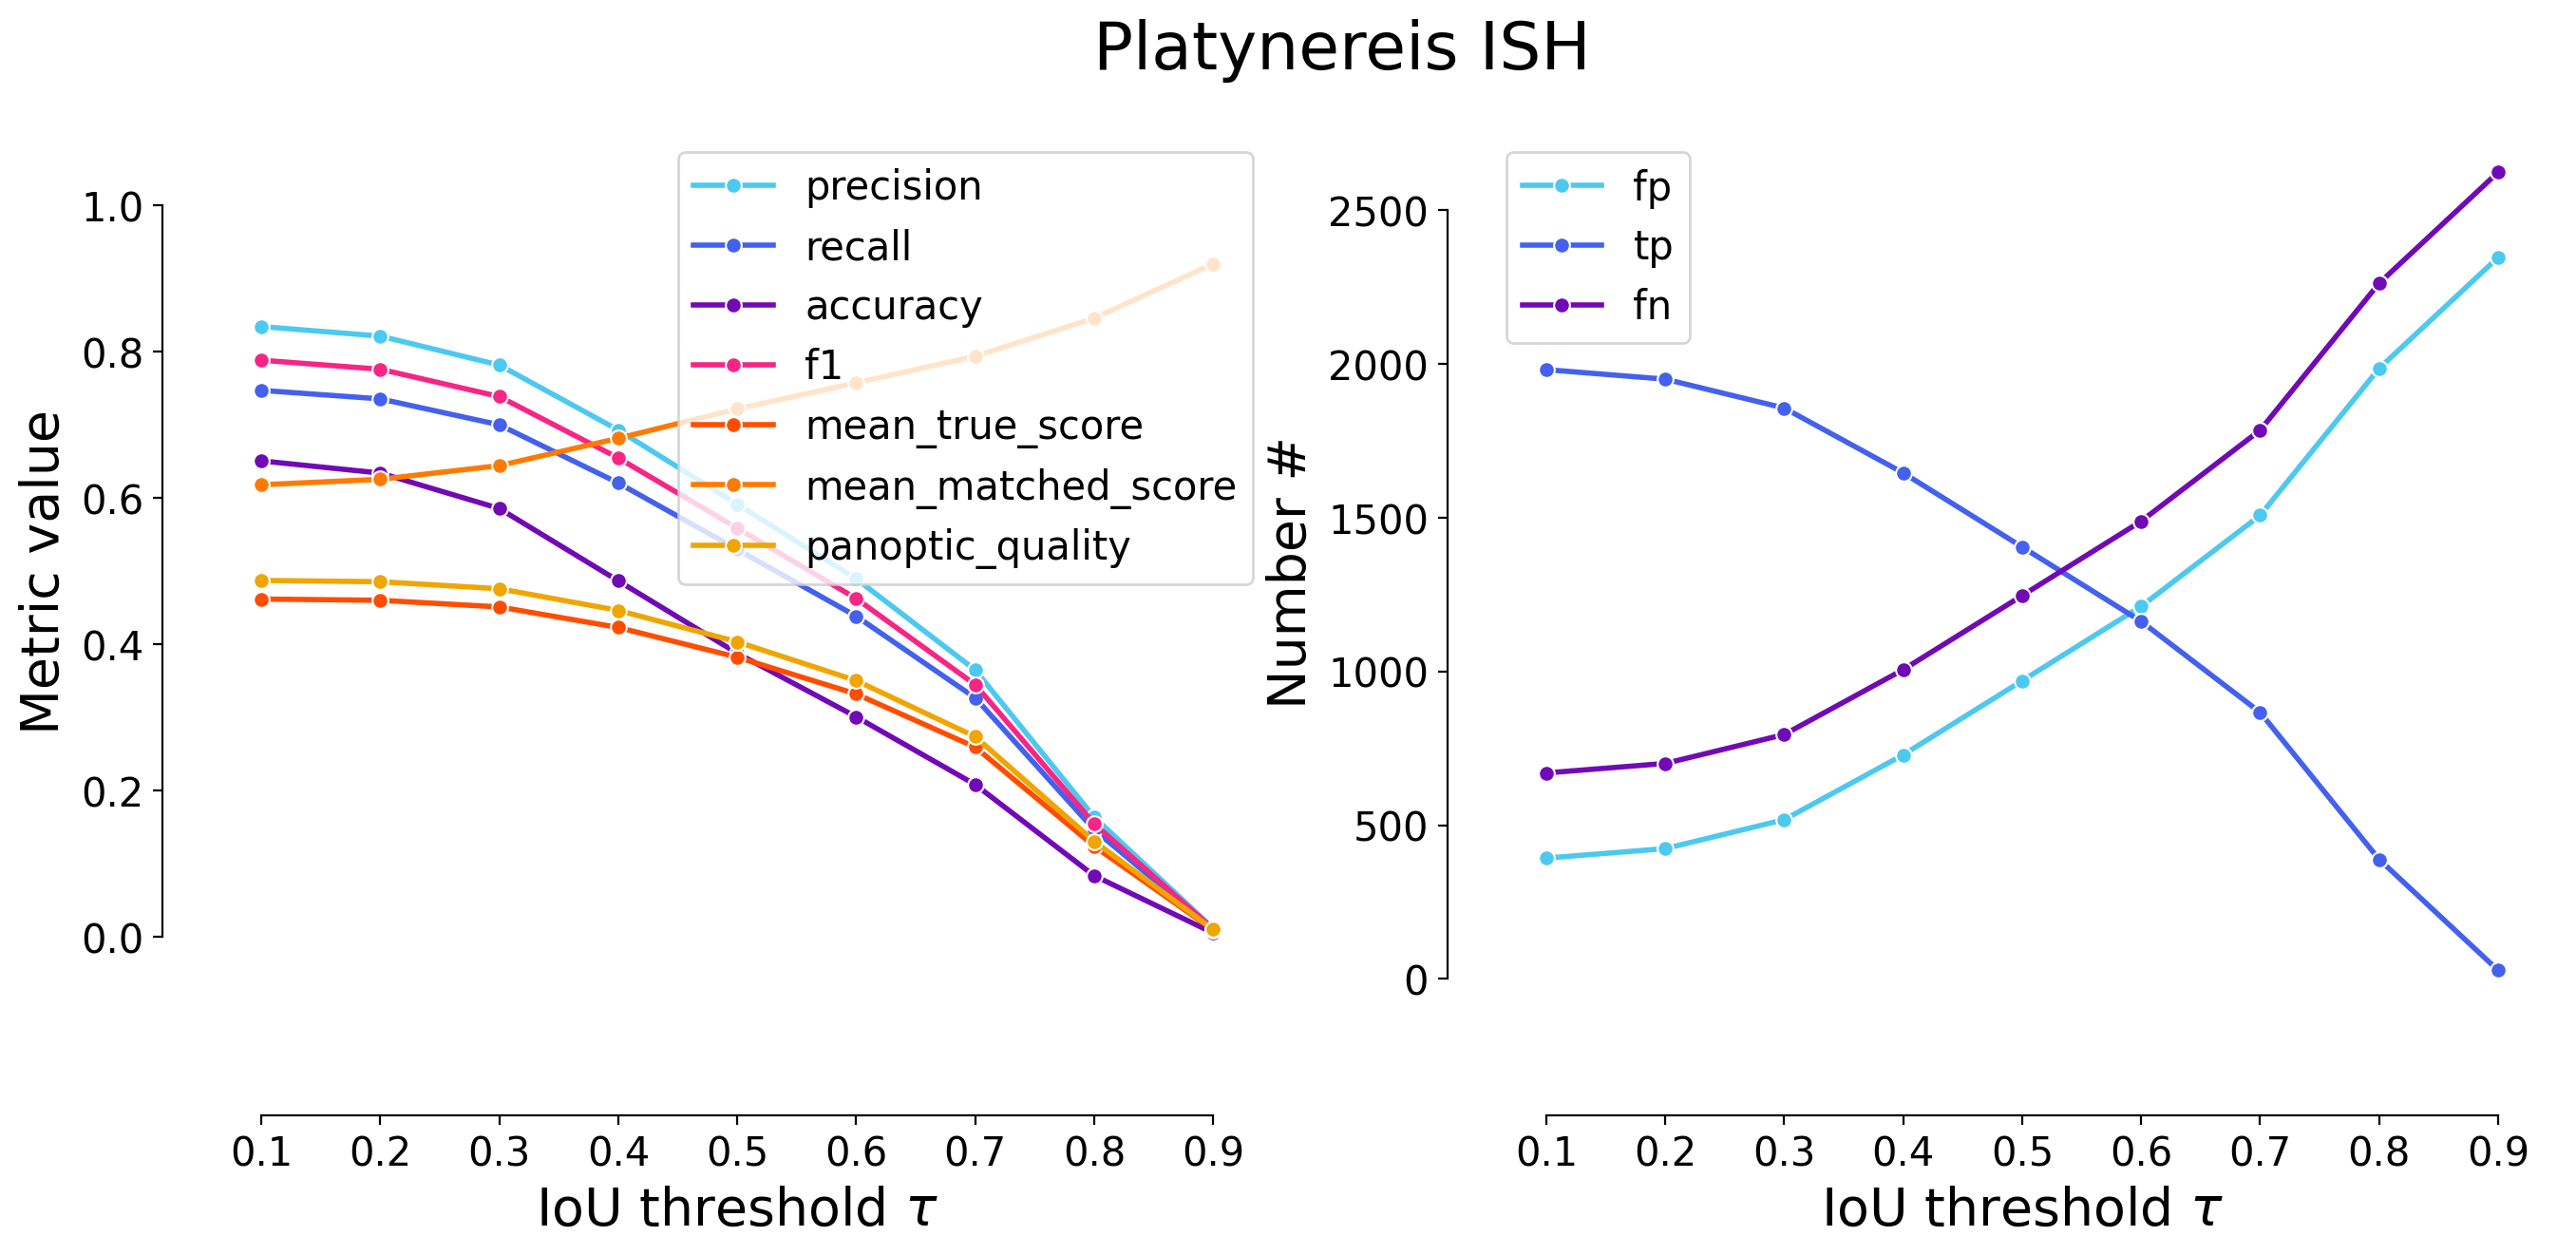

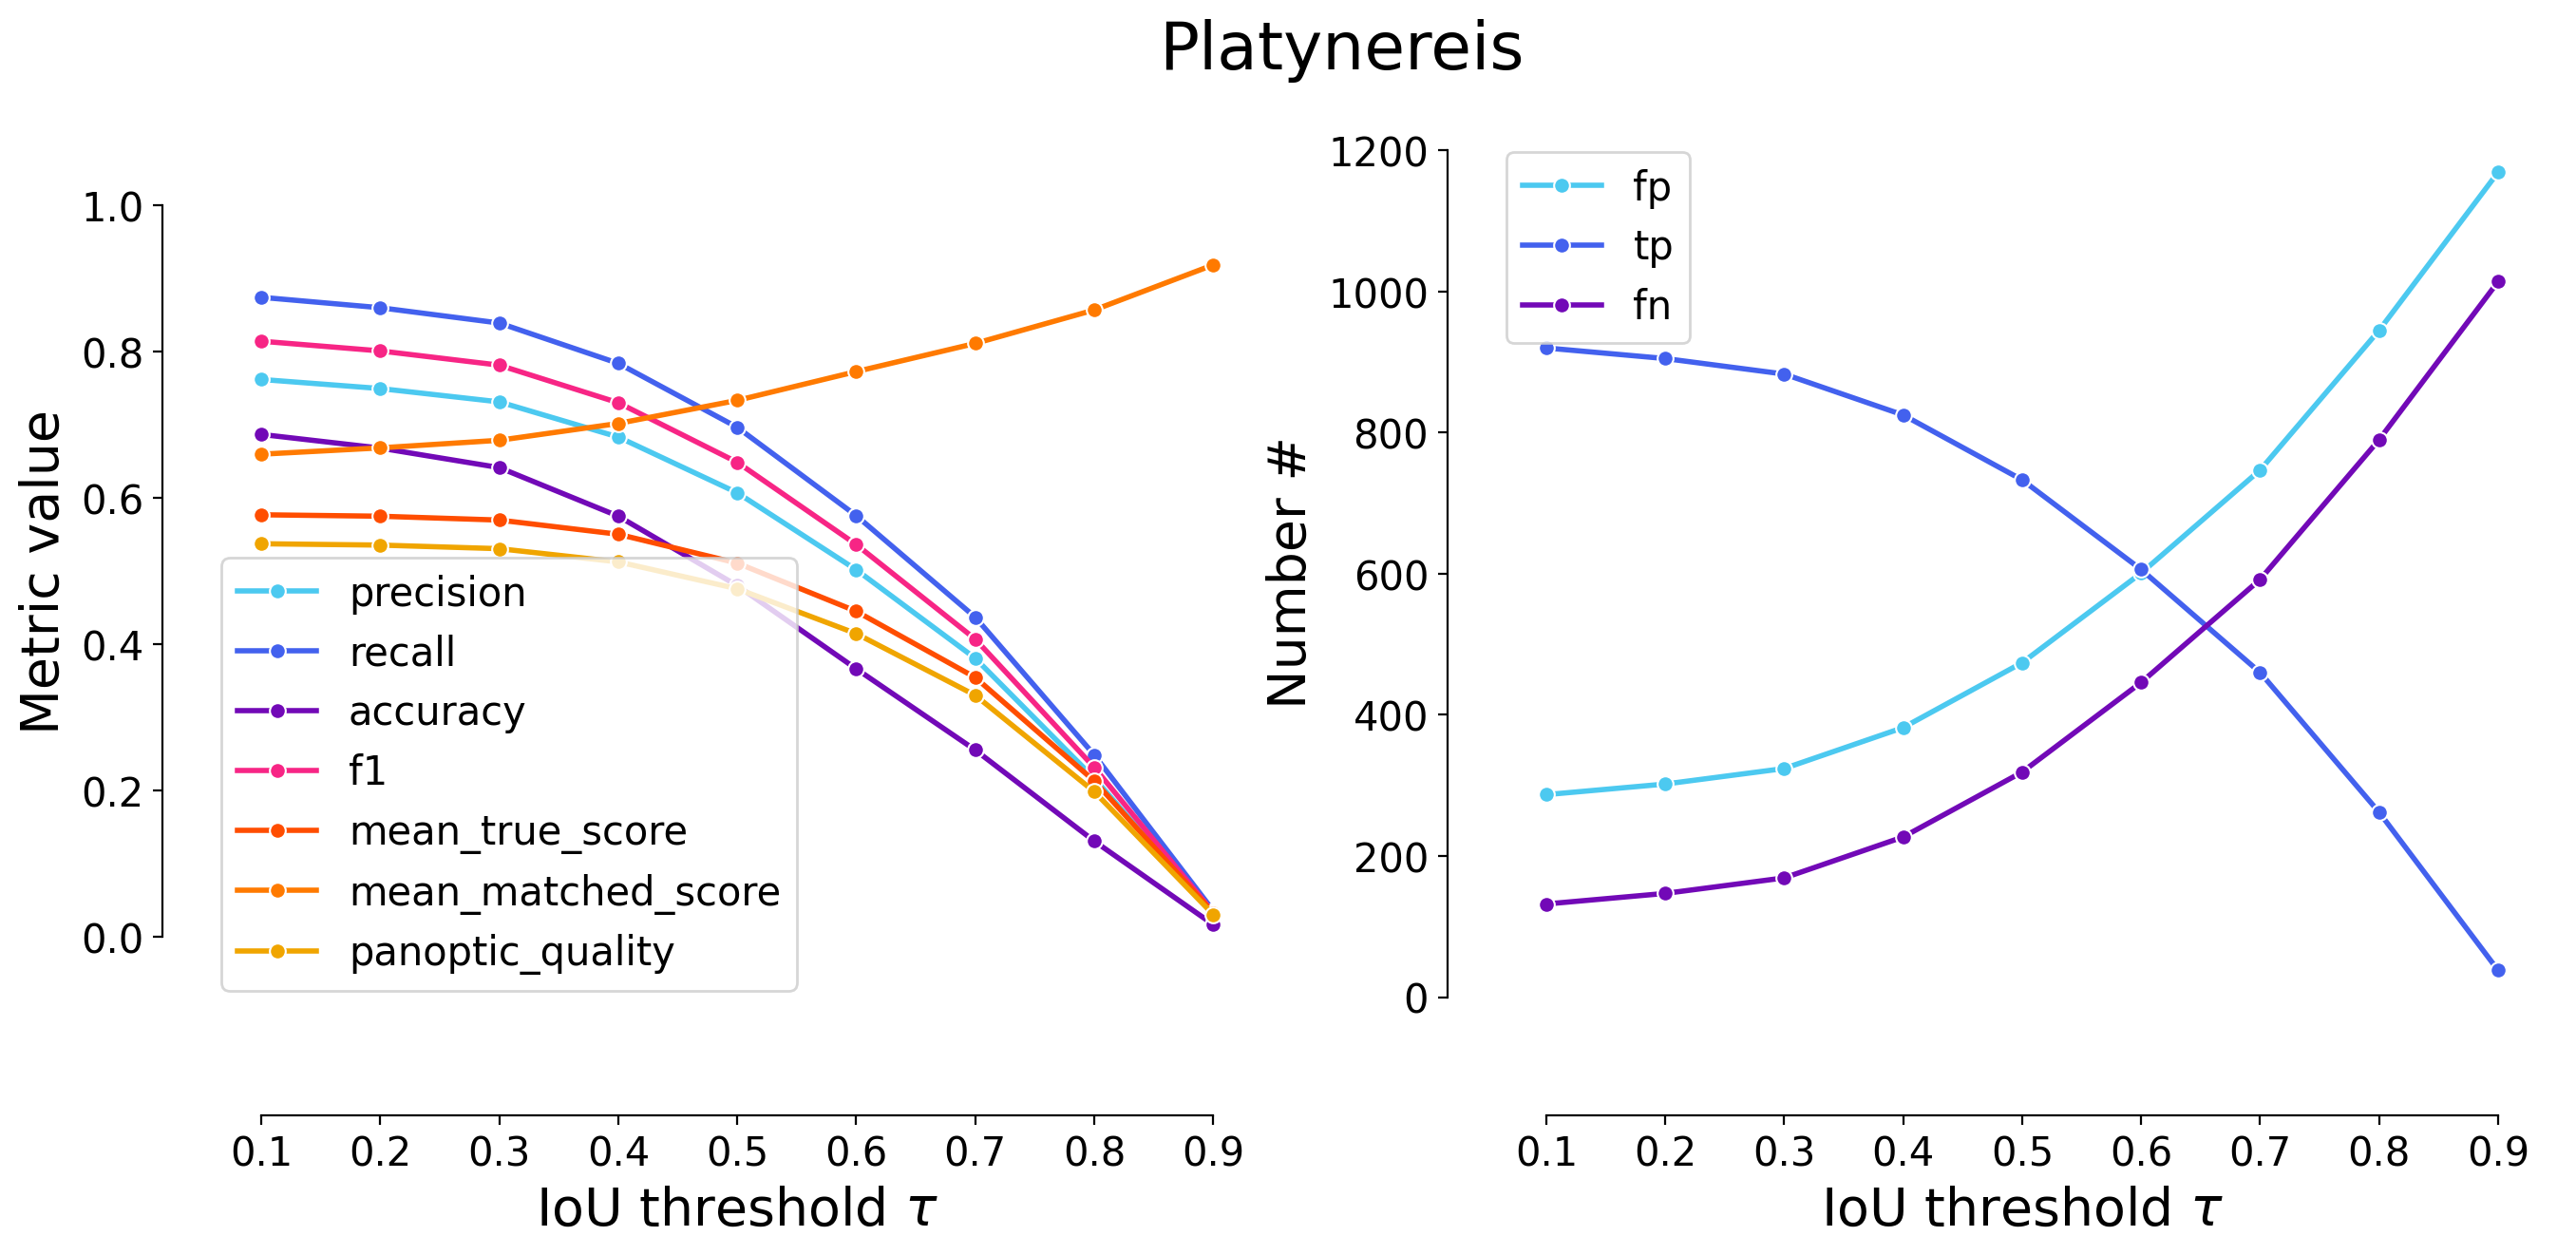

In [11]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predictions = [
    mouse_skull_instance,
    platynereis_ISH_instance,
    platynereis_instance,
   ]
names = [
    "Mouse skull",
    "Platynereis ISH",
    "Platynereis",
    ]

model_stats = []
names_stats = []

for i, p in enumerate(predictions):
    print(f"Validating on {names[i]}")
    stats = [matching_dataset(
        GT_labels[i], 
        p,
        thresh=t, 
        show_progress=False
        ) for t in taus]
    model_stats.append(stats)
    for t in taus:
        names_stats.append(names[i])
    # uncomment for ALL plots : 
    plot_performance(taus, stats, name=names[i])
    print("*"*20)

In [12]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats]
df = pd.concat(dfs)
df["Dataset"] = names_stats
df

,criterion,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality,by_image,Dataset
thresh,,,,,,,,,,,,,,,
0.1,iou,18539,4268,638,0.187136,0.869955,0.182043,0.308014,4906,22807,0.264486,0.304022,0.093643,False,Mouse skull
0.2,iou,20052,2755,2151,0.120796,0.561557,0.110385,0.198824,4906,22807,0.217073,0.386556,0.076856,False,Mouse skull
0.3,iou,21152,1655,3251,0.072565,0.337342,0.063512,0.119439,4906,22807,0.162339,0.481230,0.057477,False,Mouse skull
0.4,iou,21783,1024,3882,0.044898,0.208724,0.038368,0.073900,4906,22807,0.117976,0.565223,0.041770,False,Mouse skull
0.5,iou,22231,576,4330,0.025255,0.117407,0.021226,0.041569,4906,22807,0.077014,0.655952,0.027267,False,Mouse skull
0.6,iou,22499,308,4598,0.013505,0.062780,0.011239,0.022228,4906,22807,0.047222,0.752175,0.016719,False,Mouse skull
0.7,iou,22619,188,4718,0.008243,0.038320,0.006830,0.013568,4906,22807,0.031536,0.822950,0.011165,False,Mouse skull
0.8,iou,22693,114,4792,0.004998,0.023237,0.004131,0.008227,4906,22807,0.020157,0.867471,0.007137,False,Mouse skull
0.9,iou,22779,28,4878,0.001228,0.005707,0.001011,0.002021,4906,22807,0.005221,0.914858,0.001849,False,Mouse skull


In [15]:
df = df[df["Dataset"] != "Mouse skull"]

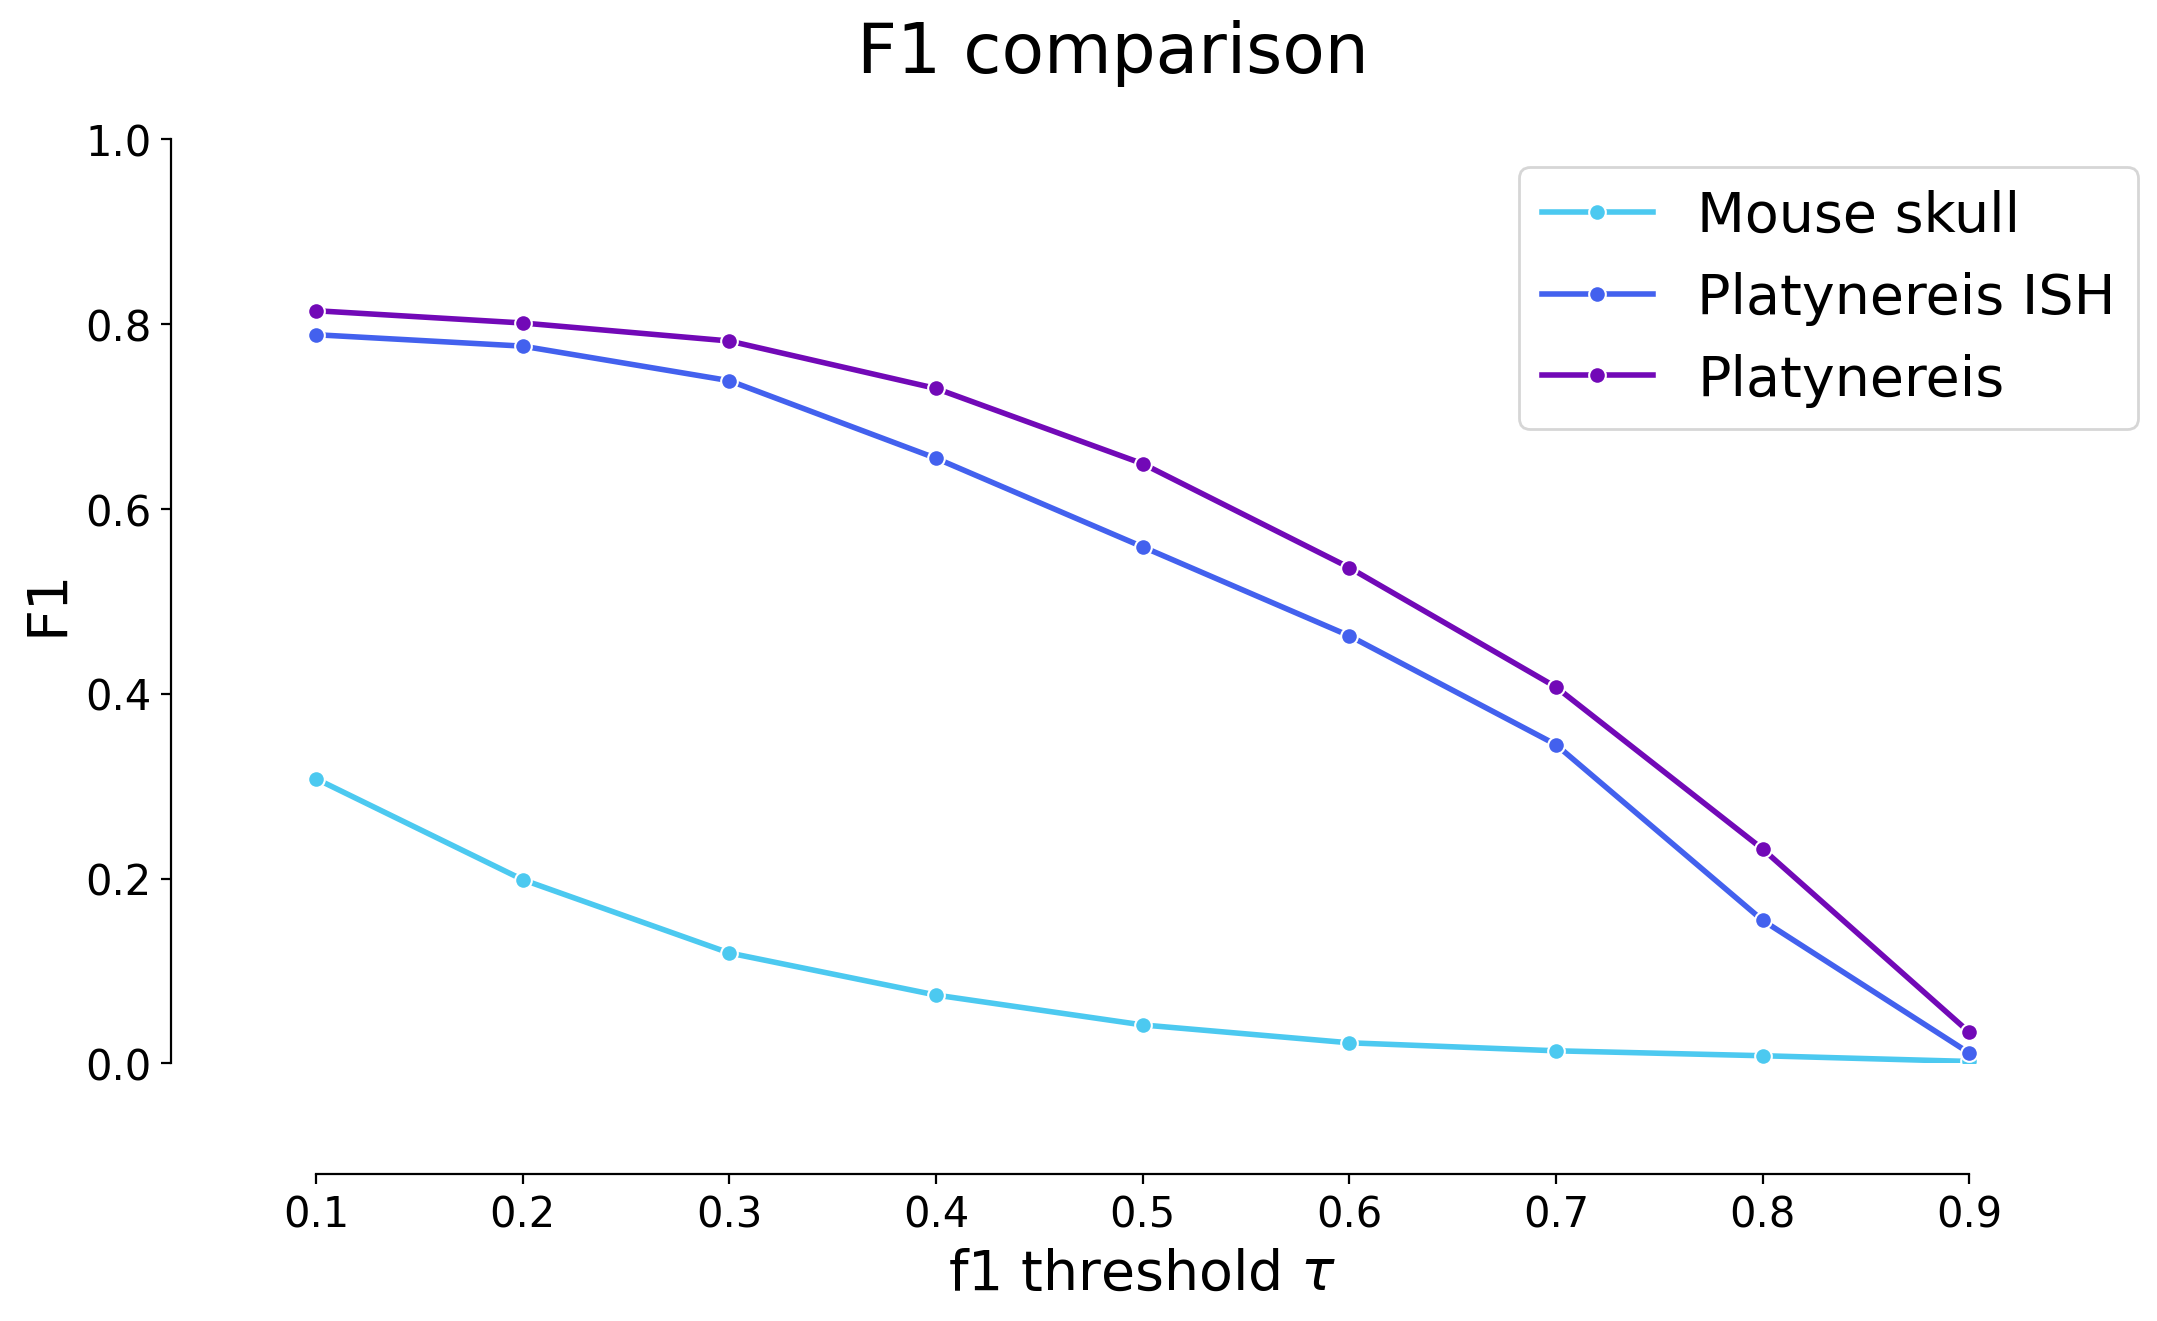

In [19]:
plot_stat_comparison(taus=taus, stats_list=model_stats, model_names=names, metric="f1")